In [22]:
import pandas as pd
import datetime
import numpy as np
import warnings

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei']  # 中文
plt.rcParams['axes.unicode_minus'] = False  # 负号
path = "D:/program/program1/User_portrait/"

### 加载数据

In [23]:
data_company = pd.read_csv(path + "20190301.csv", names = ['order_date', 'company', 'total_freight'])

In [24]:
len(data_company['company'].unique())

223577

### 排除异常订单（目前按非内部件，运费小于1的判断为异常订单）

In [25]:
data_company = data_company[data_company['total_freight'] >= 1]

### RFM

In [26]:
data_company['order_date'] = pd.to_datetime(data_company['order_date'], format = '%Y-%m-%d')
data_company['data_diff'] = pd.to_datetime('today') - data_company['order_date']
data_company['data_diff'] = data_company['data_diff'].dt.days

In [27]:
R_data = data_company.groupby(by = 'company')['data_diff'].agg({'recency' : np.min})
F_data = data_company.groupby(by = 'company')['order_date'].agg({'frequency':np.size})
M_data = data_company.groupby(by = 'company')['total_freight'].agg({'monetary':np.sum})

In [28]:
rfm_data = pd.concat([R_data, F_data, M_data], axis = 1)

In [29]:
rfm_data.describe()

,recency,frequency,monetary
count,223501.000000,223501.000000,2.235010e+05
mean,79.388110,16.527944,1.664445e+04
std,43.466182,30.518144,1.276432e+05
min,27.000000,1.000000,1.000000e+00
25%,43.000000,1.000000,3.640000e+02
50%,62.000000,3.000000,1.275900e+03
75%,108.000000,14.000000,5.489100e+03
max,187.000000,161.000000,2.348320e+07


In [30]:
rfm_data['monetary'].describe()

count    2.235010e+05
mean     1.664445e+04
std      1.276432e+05
min      1.000000e+00
25%      3.640000e+02
50%      1.275900e+03
75%      5.489100e+03
max      2.348320e+07
Name: monetary, dtype: float64

In [31]:
rfm_data['monetary'].quantile(q = np.linspace(0,1,6), interpolation = 'nearest')

0.0           1.0
0.2         280.0
0.4         771.4
0.6        2184.0
0.8        8106.0
1.0    23483204.8
Name: monetary, dtype: float64

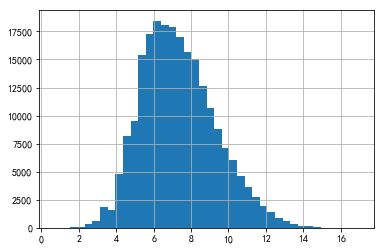

In [32]:
np.log1p(rfm_data['monetary']).hist(bins = 40)

In [33]:
rfm_data.dropna(axis = 0, inplace = True)

In [34]:
rfm_data.head()

,recency,frequency,monetary
company,,,
01个人刘健,67,2,669.00
3M苏州,84,8,4452.50
66号定制家居,45,6,12928.60
Dotwil点为商城,36,4,635.79
IT中心测试,44,3,217.00


### 与RFM均值比较

In [35]:
rfm_data['R_label'] = 0
rfm_data['F_label'] = 0
rfm_data['M_label'] = 0
rfm_data.loc[rfm_data['recency'] < rfm_data['recency'].mean(), ['R_label']] = 1
rfm_data.loc[rfm_data['frequency'] > rfm_data['frequency'].mean(), ['F_label']] = 1
rfm_data.loc[rfm_data['monetary'] > rfm_data['monetary'].mean(), ['M_label']] = 1

### 与RFM得分均值比较

In [36]:
# def create_label(data, n, mark):
#     bins = data.quantile(q = np.linspace(0,1,n), interpolation = 'nearest')
#     bins[0] = 0
#     if mark == 1:
#         labels = [5, 4, 3, 2, 1]
#     elif mark == 2:
#         labels = [1, 2, 3, 4, 5]
#     else:
#         labels = [1, 2, 3, 4, 5, 6, 7, 8]
#     label = pd.cut(data, bins = bins, labels = labels)
#     return label

In [37]:
# R_S = create_label(rfm_data['recency'], 6, 1)
# F_S = create_label(rfm_data['frequency'], 6, 2)
# M_S = create_label(rfm_data['monetary'], 6, 2)

In [38]:
# rfm_data['R_S'] = R_S
# rfm_data['F_S'] = F_S
# rfm_data['M_S'] = M_S

In [39]:
# rfm_data = rfm_data.assign(R_label = rfm_data['R_S'].map(lambda x : 1 if x > rfm_data['R_S'].astype(int).mean() else 0),
#                            F_label = rfm_data['F_S'].map(lambda x : 1 if x > rfm_data['F_S'].astype(int).mean() else 0),
#                            M_label = rfm_data['M_S'].map(lambda x : 1 if x > rfm_data['M_S'].astype(int).mean() else 0))

In [40]:
rfm_data.head()

,recency,frequency,monetary,R_label,F_label,M_label
company,,,,,,
01个人刘健,67,2,669.00,1,0,0
3M苏州,84,8,4452.50,0,0,0
66号定制家居,45,6,12928.60,1,0,0
Dotwil点为商城,36,4,635.79,1,0,0
IT中心测试,44,3,217.00,1,0,0


In [41]:
rfm_data['rfm'] = rfm_data['R_label'].map(str) + rfm_data['F_label'].map(str) + rfm_data['M_label'].map(str)

In [42]:
rfm_data['custom'] = np.NaN
rfm_data.loc[rfm_data['rfm'] == '111', ['custom']] = '重要价值客户'
rfm_data.loc[rfm_data['rfm'] == '011', ['custom']] = '重要保持客户'
rfm_data.loc[rfm_data['rfm'] == '101', ['custom']] = '重要发展客户'
rfm_data.loc[rfm_data['rfm'] == '001', ['custom']] = '重要挽留客户'
rfm_data.loc[rfm_data['rfm'] == '110', ['custom']] = '一般价值客户'
rfm_data.loc[rfm_data['rfm'] == '100', ['custom']] = '一般发展客户'
rfm_data.loc[rfm_data['rfm'] == '010', ['custom']] = '一般保持客户'
rfm_data.loc[rfm_data['rfm'] == '000', ['custom']] = '一般挽留客户'

In [43]:
rfm_data.head()

,recency,frequency,monetary,R_label,F_label,M_label,rfm,custom
company,,,,,,,,
01个人刘健,67,2,669.00,1,0,0,100,一般发展客户
3M苏州,84,8,4452.50,0,0,0,000,一般挽留客户
66号定制家居,45,6,12928.60,1,0,0,100,一般发展客户
Dotwil点为商城,36,4,635.79,1,0,0,100,一般发展客户
IT中心测试,44,3,217.00,1,0,0,100,一般发展客户


In [52]:
rfm_c1 = list(rfm_data['custom'].value_counts().sort_index()) # 统计每个类别个数
rfm_c2 = list(rfm_data['custom'].value_counts().sort_index()/len(rfm_data)*100)
rfm_c3 = list(map(lambda x: round(x, 2), rfm_c2))
# 每个类别金额占比
rfm_sum = rfm_data['monetary'].groupby(rfm_data['custom']).sum()
rfm_percent = rfm_sum/rfm_data['monetary'].sum() * 100
rfm_c4 = rfm_percent.map(lambda x : round(x, 2))

rfm_c = pd.DataFrame({'数量': rfm_c1, '客户类型占比(%)': rfm_c3, '运费占比(%)' : rfm_c4})
rfm_c

,数量,客户类型占比(%),运费占比(%)
custom,,,
一般价值客户,23292,10.42,4.81
一般保持客户,1178,0.53,0.19
一般发展客户,86166,38.55,5.15
一般挽留客户,84417,37.77,2.48
重要价值客户,26018,11.64,84.54
重要保持客户,516,0.23,1.16
重要发展客户,1483,0.66,1.21
重要挽留客户,431,0.19,0.46


([<matplotlib.patches.Wedge at 0x175ab351198>,
 [Text(1.04157,0.353727,'一般价值客户'),
  Text(0.861229,0.684313,'一般保持客户'),
  Text(-0.354872,1.04118,'一般发展客户'),
  Text(-0.443713,-1.00654,'一般挽留客户'),
  Text(0.998213,-0.462137,'重要价值客户'),
  Text(1.09798,-0.0666617,'重要保持客户'),
  Text(1.09941,-0.0359369,'重要发展客户'),
  Text(1.09998,-0.00656642,'重要挽留客户')],
 [Text(0.568132,0.192942,'10.4%'),
  Text(0.469761,0.373262,'0.5%'),
  Text(-0.193566,0.567919,'38.6%'),
  Text(-0.242025,-0.549021,'37.8%'),
  Text(0.54448,-0.252075,'11.6%'),
  Text(0.598897,-0.0363609,'0.2%'),
  Text(0.59968,-0.0196019,'0.7%'),
  Text(0.599989,-0.00358168,'0.2%')])

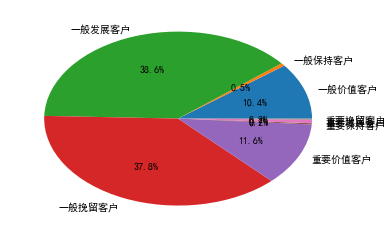

In [63]:
p = rfm_c.reset_index()
# plt.pie(p['运费占比(%)'], labels = p['custom'])
plt.pie(p['客户类型占比(%)'], labels = p['custom'], autopct = '%1.1f%%')

### RFM+KMeans

In [65]:
k_data = rfm_data[['recency', 'frequency', 'monetary']]

In [16]:
# min_max = k_data.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
# min_max.head()

,recency,frequency,monetary
company,,,
01个人刘健,0.25000,0.00625,0.000028
3M苏州,0.35625,0.04375,0.000190
66号定制家居,0.11250,0.03125,0.000551
Dotwil点为商城,0.05625,0.01875,0.000027
IT中心测试,0.10625,0.01250,0.000009


In [66]:
min_max =(k_data-k_data.mean())/k_data.std()
min_max.head()

,recency,frequency,monetary
company,,,
01个人刘健,-0.285006,-0.476043,-0.125157
3M苏州,0.106103,-0.279438,-0.095516
66号定制家居,-0.791146,-0.344973,-0.029111
Dotwil点为商城,-0.998204,-0.410508,-0.125417
IT中心测试,-0.814153,-0.443275,-0.128698


In [67]:
min_max.columns = ['SR', 'SF', 'SM']

1
2
3
4
5
6
7
8
9
10
11
12
13
14


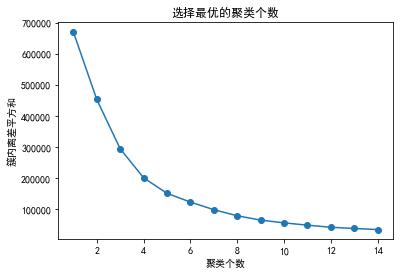

In [68]:
K = range(1,15)
GSSE = []
for k in K:
    print(k)
    SSE = []
    kmeans = KMeans(n_clusters=k, random_state=21)
    kmeans.fit(min_max)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    SSE.append(kmeans.inertia_)
    GSSE.append(np.sum(SSE))

# kmeans.inertia_ : 计算点到簇中心的距离

# 绘制K的个数与GSSE的关系
plt.plot(K, GSSE, 'o-')
plt.xlabel('聚类个数')
plt.ylabel('簇内离差平方和')
plt.title('选择最优的聚类个数')
plt.show()

In [69]:
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=21)
kmeans.fit(min_max)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=21, tol=0.0001, verbose=0)

In [70]:
k_data['cluster'] = kmeans.labels_ + 1

In [71]:
rfm_data['cluster']=k_data["cluster"]
rfm_data['cluster'] = rfm_data['cluster']
# 计算每个类别的数据量
kmeans_c1 = list(k_data["cluster"].value_counts().sort_index())

# 计算每个类别所占的百分比
kmeans_c2 = list(k_data["cluster"].value_counts().sort_index() / len(k_data) * 100)
kmeans_c3 = (list(map(lambda x: str(round(x, 2)) + "%", kmeans_c2)))

# 每个类别金额占比
kmeans_sum = k_data['monetary'].groupby(k_data['cluster']).sum()
kmeans_percent = kmeans_sum/k_data['monetary'].sum() * 100
kmeans_c4 = kmeans_percent.map(lambda x : str(round(x, 2)) + "%")

kmeans_c = pd.DataFrame({"cluster": range(1, len(kmeans_c1) + 1), "数量": kmeans_c1, "客户类型占比": kmeans_c3, "运费" : kmeans_sum, "运费占比" : kmeans_c4})
kmeans_c

,cluster,数量,客户类型占比,运费,运费占比
cluster,,,,,
1,1,21913,9.8%,6.620705e+08,17.8%
2,2,53864,24.1%,9.521846e+07,2.56%
3,3,909,0.41%,8.428050e+08,22.66%
4,4,12360,5.53%,1.307050e+09,35.14%
5,5,85,0.04%,3.012470e+08,8.1%
6,6,6,0.0%,7.964562e+07,2.14%
7,7,39747,17.78%,4.698149e+07,1.26%
8,8,94617,42.33%,3.850321e+08,10.35%


In [92]:
rfm_data[rfm_data['cluster'] == 8]['custom'].value_counts()

一般发展客户    78944
一般价值客户    11632
重要价值客户     2605
重要发展客户     1436
Name: custom, dtype: int64

In [81]:
rfm_data[rfm_data.index == '苏州爱果乐']

,recency,frequency,monetary,R_label,F_label,M_label,rfm,custom,cluster
company,,,,,,,,,
苏州爱果乐,36,140,1995265.17,1,1,1,111,重要价值客户,3


In [94]:
# tmp = rfm_data[rfm_data['cluster'] == 8]
# tmp[tmp['custom'] == '一般发展客户'].head(10)

,recency,frequency,monetary,R_label,F_label,M_label,rfm,custom,cluster
company,,,,,,,,,
01个人刘健,67,2,669.00,1,0,0,100,一般发展客户,8
66号定制家居,45,6,12928.60,1,0,0,100,一般发展客户,8
Dotwil点为商城,36,4,635.79,1,0,0,100,一般发展客户,8
IT中心测试,44,3,217.00,1,0,0,100,一般发展客户,8
IT部测试客户,44,2,26.40,1,0,0,100,一般发展客户,8
J-VALVES,45,4,5090.00,1,0,0,100,一般发展客户,8
JoinmaxHK,55,1,385.70,1,0,0,100,一般发展客户,8
mimicat,49,1,696.00,1,0,0,100,一般发展客户,8
一言手袋,41,11,4440.50,1,0,0,100,一般发展客户,8


In [83]:
rfm_data.head()

,recency,frequency,monetary,R_label,F_label,M_label,rfm,custom,cluster
company,,,,,,,,,
01个人刘健,67,2,669.00,1,0,0,100,一般发展客户,8
3M苏州,84,8,4452.50,0,0,0,000,一般挽留客户,2
66号定制家居,45,6,12928.60,1,0,0,100,一般发展客户,8
Dotwil点为商城,36,4,635.79,1,0,0,100,一般发展客户,8
IT中心测试,44,3,217.00,1,0,0,100,一般发展客户,8


rfm_data.to_csv(path + "rfm_result.csv", encoding = 'gbk')

### 聚类结果可视化

In [84]:
min_max['cluster'] = kmeans.labels_
min_max.head()

,SR,SF,SM,cluster
company,,,,
01个人刘健,-0.285006,-0.476043,-0.125157,7
3M苏州,0.106103,-0.279438,-0.095516,1
66号定制家居,-0.791146,-0.344973,-0.029111,7
Dotwil点为商城,-0.998204,-0.410508,-0.125417,7
IT中心测试,-0.814153,-0.443275,-0.128698,7


In [85]:
rfm_data['cluster'].value_counts()

8    94617
2    53864
7    39747
1    21913
4    12360
3      909
5       85
6        6
Name: cluster, dtype: int64

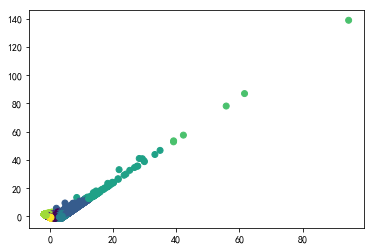

In [89]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 'mle', svd_solver = 'full')
pca.fit(min_max[['SR', 'SF', 'SM']])
result = pca.transform(min_max[['SR', 'SF', 'SM']])
# pca.explained_variance_ratio_
plt.scatter(result[:,0], result[:, 1], c = min_max['cluster'], marker = 'o')

In [ ]:
# BRICH层次聚类
# DBSCAN密度聚类

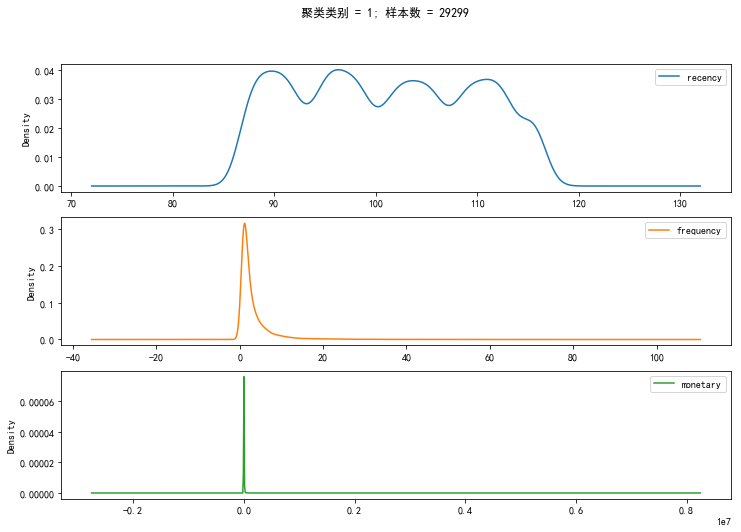

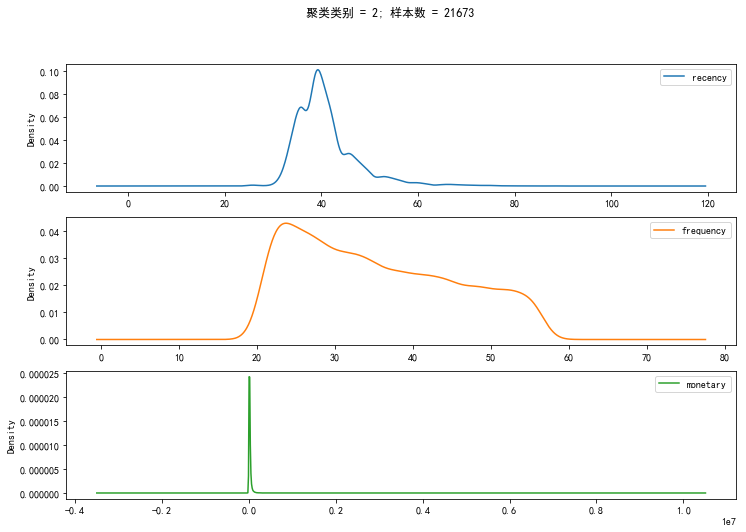

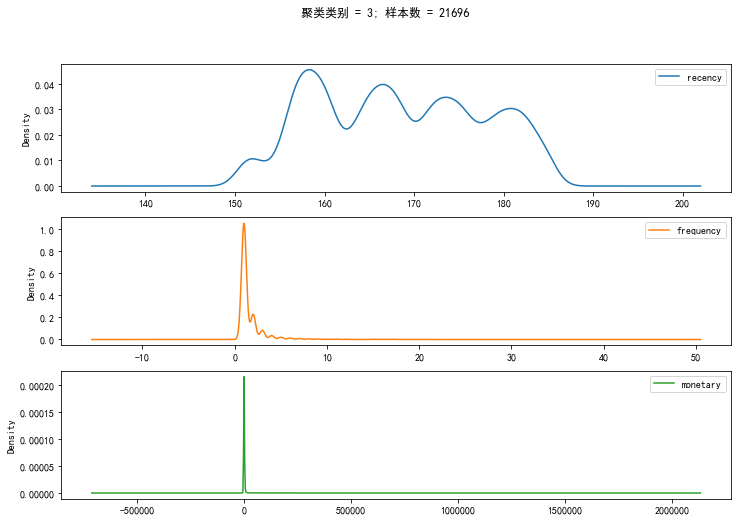

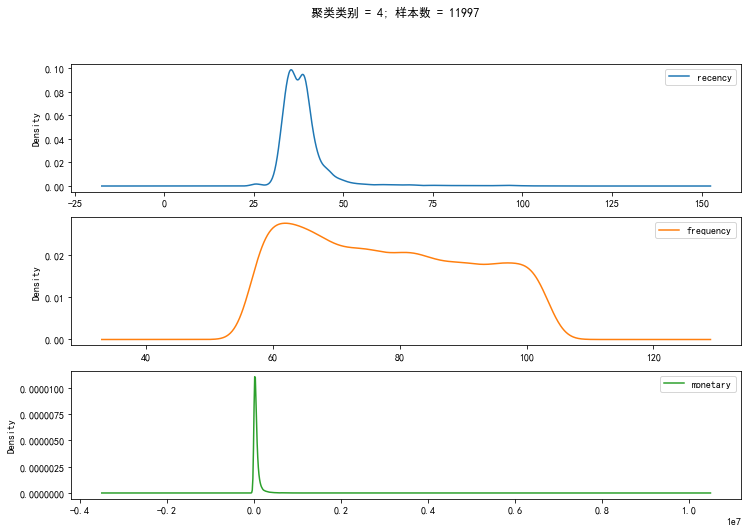

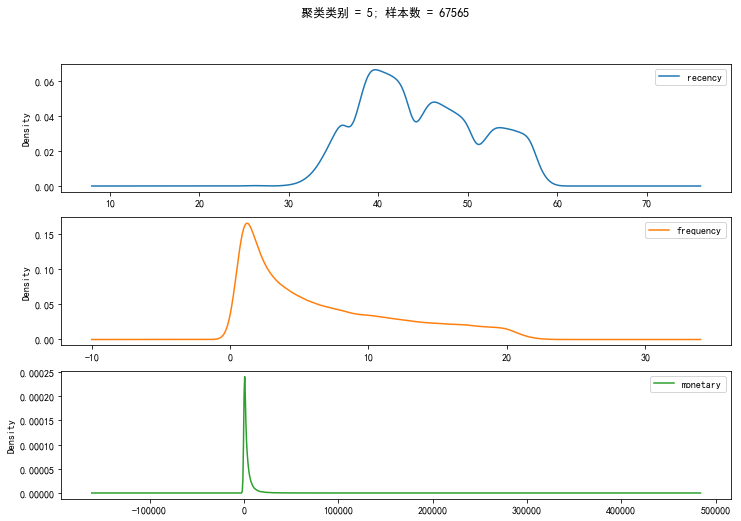

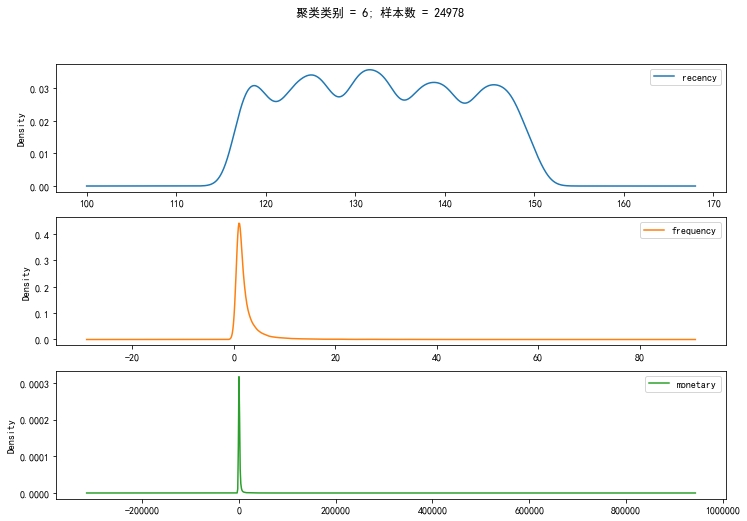

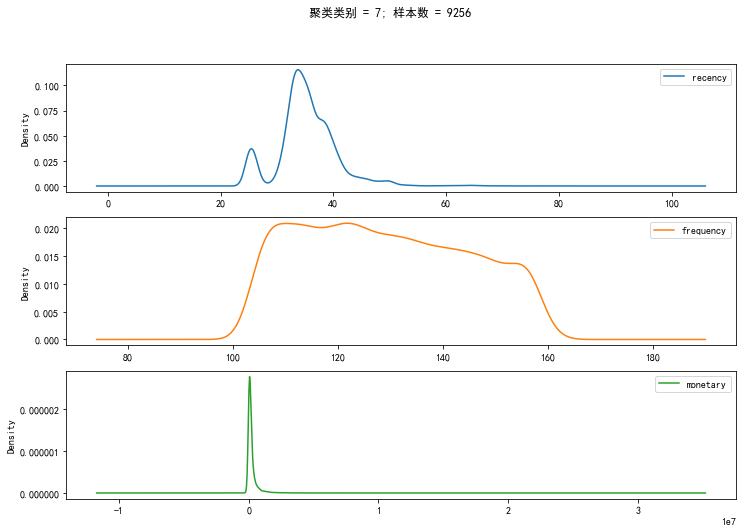

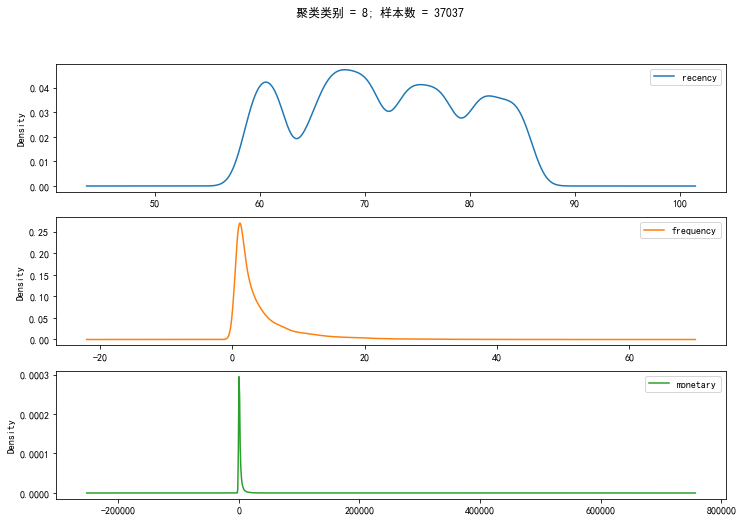

In [35]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
for i in range(1,9):
        cls=rfm_data.loc[rfm_data['cluster']==i, ['recency', 'frequency', 'monetary']]
        cls.plot(kind='kde',subplots=True,sharex=False, figsize=(12,8))
        plt.suptitle('聚类类别 = %d; 样本数 = %d' % (i, rfm_data[rfm_data['cluster'] == i]['cluster'].value_counts()))
plt.legend()
plt.show()